In [26]:
from google.colab.patches import cv2_imshow

In [27]:
import sys
from enum import Enum
from math import sqrt
import cv2
import numpy as np

class ConvolutionType(Enum):
    MeanFilter = 1
    Sobel_X = 2
    Sobel_Y = 3
    Laplace = 4

class UnsharpService:
    def __init__(self, threshold):
        self.__threshold = threshold

        self.__mean_mask = [1, 1, 1,
                            1, 1, 1,
                            1, 1, 1]

        self.__sobelx_mask = [-1, 0, 1,
                               -2, 0, 2,
                               -1, 0, 1]

        self.__sobely_mask = [-1, -2, -1,
                               0, 0, 0,
                               1, 2, 1]

        self.__laplace_mask = [-1, -1, -1,
                               -1, 8, -1,
                               -1, -1, -1]

    def averageBlur(self, img):
        rows = img.shape[0]
        cols = img.shape[1]
        mean_img = np.zeros((rows, cols), dtype=img.dtype)
        self.__convolution(img, mean_img, self.__mean_mask, ConvolutionType.MeanFilter)
        return mean_img

    def __sobelx(self, src, out):
        self.__convolution(src, out, self.__sobelx_mask, ConvolutionType.Sobel_X)

    def __sobely(self, src, out):
        self.__convolution(src, out, self.__sobely_mask, ConvolutionType.Sobel_Y)

    def firstOrderEdge(self, img):
        rows = img.shape[0]
        cols = img.shape[1]
        sobely_img = np.zeros((rows, cols), dtype=img.dtype)
        sobelx_img = np.zeros((rows, cols), dtype=img.dtype)
        diff_1_img = np.zeros((rows, cols), dtype=img.dtype)

        self.__sobely(img, sobely_img)  # sobel y
        self.__sobelx(img, sobelx_img)  # sobel x

        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                sobel = int(sobelx_img[i, j]) + int(sobely_img[i, j])
                diff_1_img[i, j] = self.__check(sobel)

        # 對一階微分結果進行均值濾波
        mean_diff_1_img = self.averageBlur(diff_1_img) # unsharp mask

        return mean_diff_1_img

    def secondOrderEdge(self, img):
        rows = img.shape[0]
        cols = img.shape[1]

        diff_2_img = np.zeros((rows, cols), dtype=img.dtype)
        self.__laplace(img, diff_2_img)

        return diff_2_img

    def __laplace(self, src, out):
        self.__convolution(src, out, self.__laplace_mask, ConvolutionType.Laplace)

    def __convolution(self, src, out, mask, conv_type):
        rows = out.shape[0]
        cols = out.shape[1]

        for i in range(1, rows - 1):
            for j in range(1, cols - 1):
                conv = mask[0] * src[i - 1, j - 1] + \
                       mask[1] * src[i - 1, j] + \
                       mask[2] * src[i - 1, j + 1] + \
                       mask[3] * src[i, j - 1] + \
                       mask[4] * src[i, j] + \
                       mask[5] * src[i, j + 1] + \
                       mask[6] * src[i + 1, j - 1] + \
                       mask[7] * src[i + 1, j] + \
                       mask[8] * src[i + 1, j + 1]

                if conv_type == ConvolutionType.MeanFilter:
                    conv = conv / 9
                    # conv = 255 if conv > self.__threshold else 0
                elif conv_type == ConvolutionType.Sobel_X or conv_type == ConvolutionType.Sobel_Y:
                    conv = abs(conv)

                out[i, j] = self.__check(conv)

    @staticmethod
    def __check(v):
        if v > 255:
            return 255
        if v < 0:
            return 0
        return v

## 原本的程式

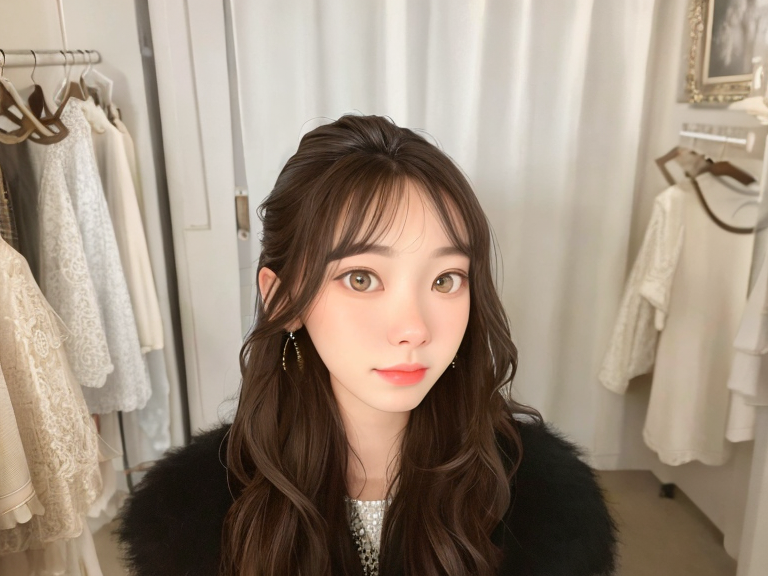

In [ ]:
img_path = 'IMG_1.PNG'
threshold = 128
input_img = cv2.imread(img_path)
cv2_imshow(input_img)

gray_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)

service = UnsharpService(threshold=threshold)
diff_1_img = service.firstOrderEdge(gray_img)
diff_2_img = service.secondOrderEdge(gray_img)

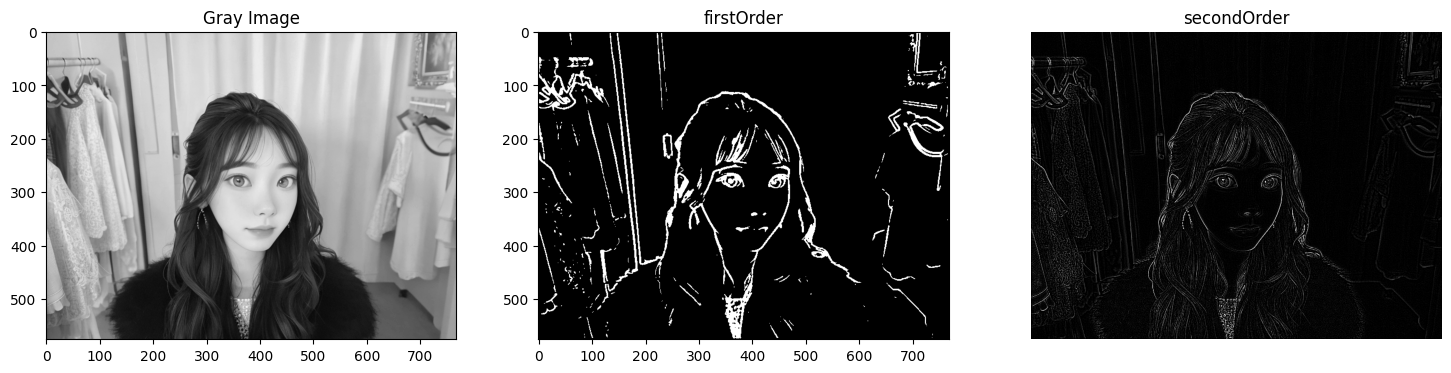

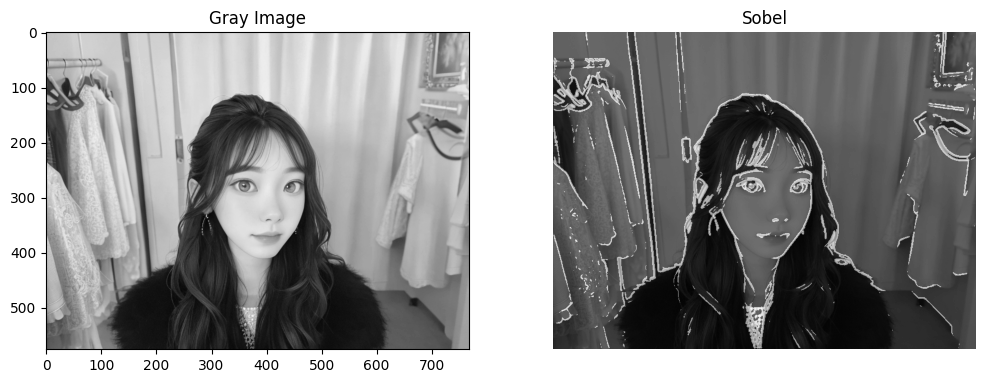

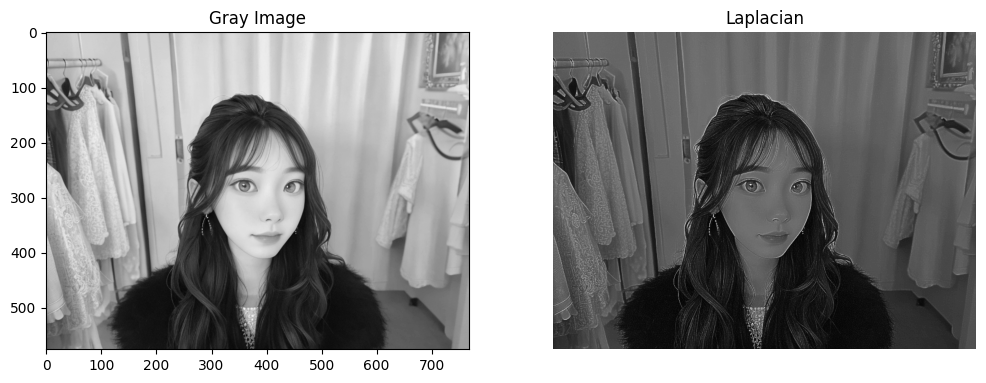

In [ ]:
import matplotlib.pyplot as plt

# 設定畫布大小
plt.figure(figsize=(18, 6))

# 顯示灰度圖像
plt.subplot(1, 3, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('Gray Image')

# 顯示一階微分結果
plt.subplot(1, 3, 2)
plt.imshow(diff_1_img, cmap='gray')
plt.title('firstOrder')

# 顯示二階微分結果
plt.subplot(1, 3, 3)
plt.imshow(diff_2_img, cmap='gray')
plt.title('secondOrder')
plt.axis('off')
plt.show()

# 確保兩張圖片的尺寸相同
if gray_img.shape != diff_1_img.shape:
    print(f"{gray_img.shape}/{diff_1_img.shape}")
    raise ValueError("The images1 must have the same size to be blended.")
if gray_img.shape != diff_2_img.shape:
    print(f"{gray_img.shape}/{ diff_2_img.shape}")
    raise ValueError("The images2 must have the same size to be blended.")

# 將兩張圖片疊加
alpha = 0.5  # 第一張圖片的權重
beta = 0.5   # 第二張圖片的權重
blended_img1 = cv2.addWeighted(gray_img, alpha, diff_1_img, beta, 0)
blended_img2 = cv2.addWeighted(gray_img, alpha, diff_2_img, beta, 0)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('Gray Image')
# 顯示 Sobel 結果
plt.subplot(1, 2, 2)
plt.imshow(blended_img1, cmap='gray')
plt.title('Sobel')
plt.axis('off')  # 隱藏坐標軸
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(gray_img, cmap='gray')
plt.title('Gray Image')
# 顯示 Laplacian 結果
plt.subplot(1, 2, 2)
plt.imshow(blended_img2, cmap='gray')
plt.title('Laplacian')
plt.axis('off')  # 隱藏坐標軸
plt.show()

## PSNR

In [13]:
def calculate_psnr(img1, img2):
    mse = np.mean((img1 - img2) ** 2)
    if mse == 0:
        return float('inf')  # 避免除以零的情況，如果兩張圖片完全相同
    pixel_max = 255.0
    psnr = 20 * np.log10(pixel_max / np.sqrt(mse))
    return psnr

## 補做的程式

In [28]:
def multiply_images( image1, image2 ):

    # 將圖片轉換為浮點數類型
    image1 = image1.astype(np.float32)
    image2 = image2.astype(np.float32)

    # 逐元素相乘
    multiplied_image = image1 * image2

    # 正規化結果到0-255之間
    multiplied_image = np.clip(multiplied_image, 0, 255)

    # 轉換回uint8類型
    multiplied_image = multiplied_image.astype(np.uint8)

    return multiplied_image


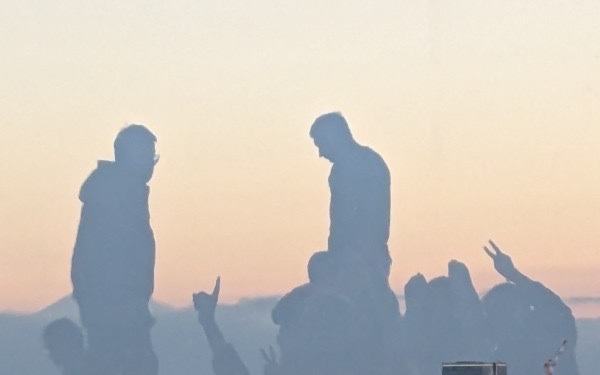

In [37]:
img_path = 'IMG_4.JPG'
threshold = 128
input_img = cv2.imread(img_path)
cv2_imshow(input_img)

gray_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2GRAY)

service = UnsharpService(threshold=threshold)
diff_2_img = service.secondOrderEdge(gray_img)


# 將兩張圖片疊加
alpha = 1  # 第一張圖片的權重
beta = 1   # 第二張圖片的權重
blended_img1 = cv2.addWeighted(gray_img, alpha, diff_2_img, beta, 0)

diff_1_img = service.firstOrderEdge(gray_img)
blur_img = service.averageBlur(diff_1_img)

# 將影像正規化到0.0到1.0之間
normalized_image = blur_img / np.max(blur_img)
multi_images1 = multiply_images(normalized_image, diff_2_img)
multi_images2 = multiply_images(normalized_image, blended_img1)

result1 = cv2.addWeighted(multi_images1, alpha, gray_img, beta, 0)
result2 = cv2.addWeighted(multi_images2, alpha, gray_img, beta, 0)

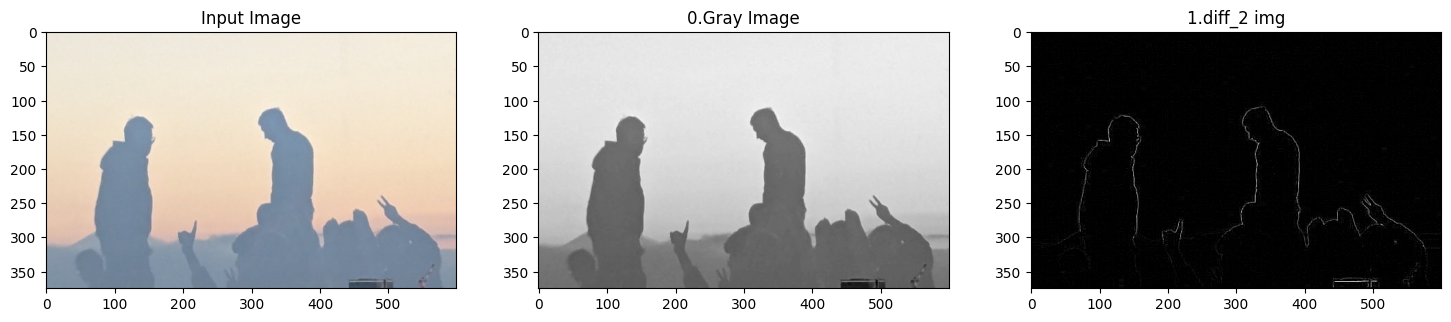

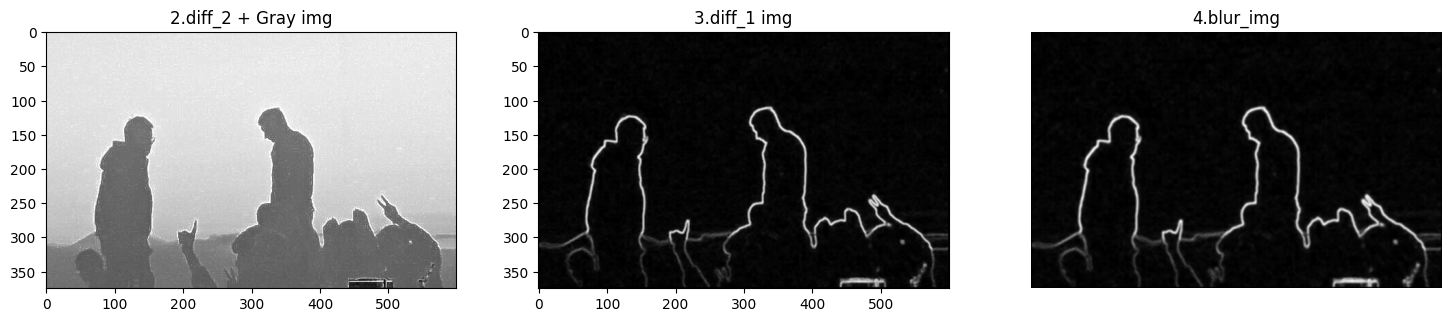

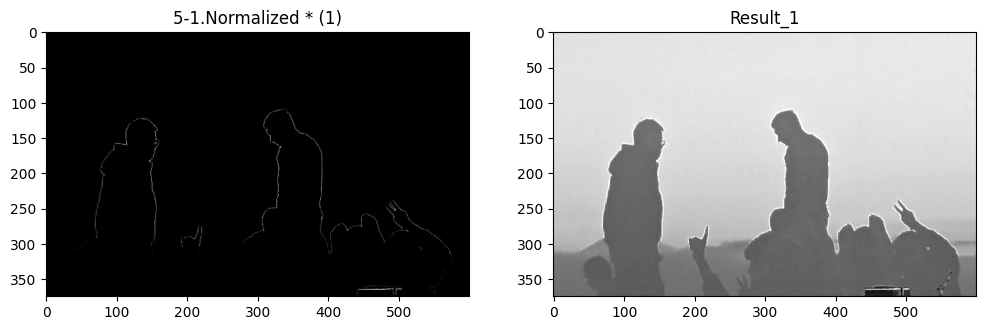

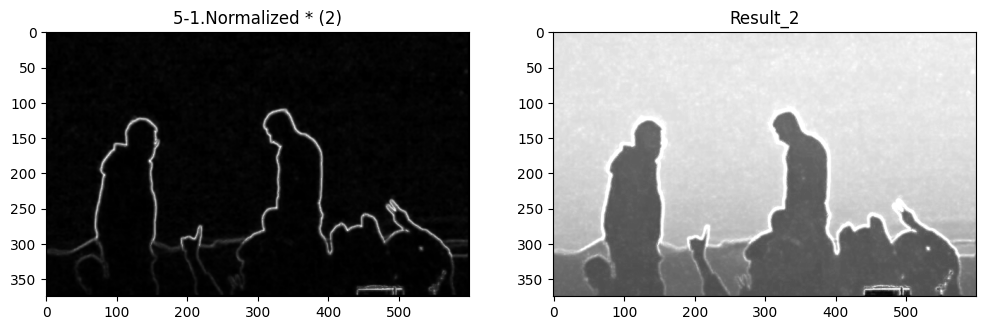

In [38]:
import matplotlib.pyplot as plt

input_img = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(input_img)
plt.title('Input Image')

plt.subplot(1, 3, 2)
plt.imshow(gray_img, cmap='gray')
plt.title('0.Gray Image')

plt.subplot(1, 3, 3)
plt.imshow(diff_2_img, cmap='gray')
plt.title('1.diff_2 img')
plt.show()

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.imshow(blended_img1, cmap='gray')
plt.title('2.diff_2 + Gray img')

plt.subplot(1, 3, 2)
plt.imshow(diff_1_img, cmap='gray')
plt.title('3.diff_1 img')

plt.subplot(1, 3, 3)
plt.imshow(blur_img, cmap='gray')
plt.title('4.blur_img')
plt.axis('off')
plt.show()

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(multi_images1, cmap='gray')
plt.title('5-1.Normalized * (1)')

plt.subplot(1, 2, 2)
plt.imshow(result1, cmap='gray')
plt.title('Result_1')
plt.show()

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(multi_images2, cmap='gray')
plt.title('5-1.Normalized * (2)')

plt.subplot(1, 2, 2)
plt.imshow(result2, cmap='gray')
plt.title('Result_2')
plt.show()


In [39]:
psnr_value1 = calculate_psnr(gray_img, result1)
print(f"PSNR Value between gray_img and result1_img is {round(psnr_value1,4)} dB")
psnr_value2 = calculate_psnr(gray_img, result2)
print(f"PSNR Value between gray_img and result2_img is {round(psnr_value2,4)} dB")

PSNR Value between gray_img and result1_img is 45.628 dB
PSNR Value between gray_img and result2_img is 33.7243 dB
